In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Check for the presence of GPU and print its name
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
# List all local devices
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18067674140529599922
 xla_global_id: -1]

In [4]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    # Print the number of available CUDA devices
    print(torch.cuda.device_count())
    
    # Print the name of the first CUDA device
    print(torch.cuda.get_device_name(0))

else:
    # Set the device to CPU
    device = torch.device("cpu")


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
import pandas as pd

txt_path = 'AnonymizedClinicalAbbreviationsAndAcronymsDataSet.txt'

# Read the CSV file into a DataFrame
data_pd = pd.read_csv(txt_path, sep="|", header=None, encoding='cp1252')

# Rename the columns
data_pd = data_pd.rename(columns={0: 'Abbreviation', 1: 'Expansion', 2: 'ABB_frm', 3: "start_pos", 4: "end_pos", 5: "info", 6: "context"}, inplace=False)

# Print the shape of the DataFrame
print(data_pd.shape)


(37500, 7)


In [7]:
data_pd.head()

,Abbreviation,Expansion,ABB_frm,start_pos,end_pos,info,context
0,AB,abortion,AB.,231.0,233.0,NaN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...
1,AB,abortion,AB.,249.0,251.0,NaN,She is now bleeding quite heavily. Ultrasound ...
2,AB,abortion,AB,223.0,224.0,PAST OB HISTORY,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...
3,AB,abortion,AB.,194.0,196.0,HISTORY OF THE PRESENT ILLNESS,She had a pelvic ultrasound at Park Nicollet o...
4,AB,abortion,AB,114.0,115.0,PAST OB-GYN HISTORY,"On _%#MMDD2007#%_, normal anatomy with anterio..."


In [8]:
data_pd=data_pd[data_pd['Abbreviation'] == 'AB']
print(data_pd.shape)

(500, 7)


In [9]:
#check number of expansion in the dataset before filtering
print(len(data_pd["Expansion"].unique()))

#filtering dataset 
data_pd.drop(data_pd[data_pd['Expansion'] == "UNSURED SENSE"].index, inplace = True)
data_pd.drop(data_pd[data_pd['Expansion'] == "GENERAL ENGLISH"].index, inplace = True)
data_pd.drop(data_pd[data_pd['Expansion'] == "NAME"].index, inplace = True)

# check dataset size after filtering
print(data_pd.shape)

12
(498, 7)


In [10]:
# fuction to assign numerical value to the expansion
def func(unique_expansion, ex):
  ex= str(ex)
  for i in unique_expansion.items():
    if i[0] == ex:
      return i[1]


In [11]:
import numpy as np

# Get unique values of Expansion column
Expansion_unique = data_pd["Expansion"].unique()

# Get context column values
context = data_pd["context"].values

# Create numerical labels for unique expansions
num = np.arange(0, 348, 1).tolist()
unique_expansion = dict(zip(Expansion_unique, num))

# Initialize a list to store all labels
all_label = []

# Iterate through each row of the DataFrame
for index, row in data_pd.iterrows():
    # Iterate through unique_expansion dictionary items
    for i in unique_expansion.items():
        # Check if the expansion in the row matches with any unique expansion
        if i[0] == row[1]:
            # Append the corresponding numerical label to all_label list
            all_label.append(i[1])


In [12]:
# Create a dictionary mapping each word in Expansion_unique to its index
word2index_dict = {word: i for (i, word) in enumerate(Expansion_unique)}


In [13]:
import pandas as pd

# Create a DataFrame from word2index_dict
label_df = pd.DataFrame(list(word2index_dict.items()), columns=['expansion', 'label'])

# Save the DataFrame to a TSV file
label_df.to_csv('label_expansion.tsv', sep='|', index=False)


In [14]:
import re
import string

def cleaning(context_):
    # Remove patterns like "_%#\S+"
    x = re.sub("_%#\S+", "", context_)
    # Remove punctuation marks
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    # Remove alphanumeric characters
    x = re.sub(r'\w*\d+\w*', '', x)
    # Replace multiple spaces with a single space
    x = re.sub('\s{2,}', " ", x)
    return x


In [15]:
import pandas as pd

# Create a new DataFrame for filtered data
filtered_data = pd.DataFrame()

# Assign cleaned text data to 'content' column
filtered_data['content'] = data_pd['context'].apply(cleaning)

# Assign Expansion column to 'expansion' column
filtered_data['expansion'] = data_pd['Expansion']

# Assign labels to 'label' column
filtered_data['label'] = all_label


In [16]:
filtered_data['label'][498]

0

In [17]:
#override dataset
class DisambiguateDataset(Dataset):

  def __init__(self, data: pd.DataFrame, tokenizer, max_token_len ):
    # Initialize the dataset with the provided DataFrame, tokenizer, and maximum token length
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    # Return the number of samples in the dataset (number of rows in the DataFrame)
    return self.data.shape[0]

  def __getitem__(self, index: int):
    # Retrieve a single sample from the dataset at the given index
    data_row = self.data.iloc[index]
    context =data_row['content']
    expansion = data_row['expansion']
    label_ = data_row['label']
      
    # Encode the expansion and context using the provided tokenize
    encoding = self.tokenizer.encode_plus(
        expansion, context, 
        add_special_tokens = True,
        max_length = 128,
        return_token_type_ids = True,
        padding = "max_length",
        truncation =True,
        return_attention_mask = True,
        return_tensors = "pt"
     
    )
    # Return a dictionary containing the encoded input IDs, attention mask, token type IDs, and the label converted to a PyTorch tensor
    return dict(
      input_ids = encoding["input_ids"].flatten(),
      attention_mask = encoding["attention_mask"].flatten(),
      token_type_ids = encoding["token_type_ids"].flatten(),
      label_ = torch.tensor(label_,dtype = torch.long)
    )



In [18]:
RANDOM_SEED = 42
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 2

# divide the data set to training and validation dataset and check the new size for both
train_df, test_df = train_test_split(filtered_data,test_size=0.2, random_state = RANDOM_SEED)
val_df, test_df = train_test_split(test_df,test_size=0.5, random_state = RANDOM_SEED)
train_df.shape, val_df.shape, test_df.shape


((398, 3), (50, 3), (50, 3))

In [19]:
test_df.columns

Index(['content', 'expansion', 'label'], dtype='object')

In [20]:
filtered_data.tail(50)

,content,expansion,label
449,"At the time of admission, her cervix was noted...",abortion,0
450,2. Spinal meningitis as a child. PAST SURGICAL...,abortion,0
451,"This pregnancy complicated by AMA, previous hi...",abortion,0
452,"The uterus itself is small, anterior and mobil...",abortion,0
453,"PAST OBSTETRICAL HISTORY: 1. _%#MM#%_ 2001, ce...",abortion,0
454,"Cervix is closed. Uterus is anteverted, 6 week...",abortion,0
455,PAST MEDICAL HISTORY: Inappropriate sinus tach...,abortion,0
456,Good fetal movement. Prenatal care started at ...,abortion,0
457,Urine culture within normal limits. Hemoglobin...,abortion,0
458,DOB: PREOP HISTORY AND PHYSICAL AND EMERGENCY ...,abortion,0


In [21]:
# Download Bio_clinicalBERT 

from transformers import AutoTokenizer, AutoModel, BertForNextSentencePrediction, BertTokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
#Download ms_bert
from transformers import AutoTokenizer, AutoModel
model_name = "NLP4H/ms_bert"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at NLP4H/ms_bert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# Get the list of named parameters from the model
params = list(model.named_parameters())

# Print the total number of different named parameters in the model
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# Print information about the embedding layer
print('==== Embedding Layer ====\n')

# Print the names and sizes of the parameters in the embedding layer
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Print information about the first transformer layer
print('\n==== First Transformer ====\n')

# Print the names and sizes of the parameters in the first transformer layer
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Print information about the output layer
print('\n==== Output Layer ====\n')

# Print the names and sizes of the parameters in the output layer
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisambiguateDataset(df, tokenizer, max_len)

  return torch.utils.data.DataLoader(ds, batch_size = batch_size, shuffle = True )  

In [25]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [26]:
data = next(iter(val_data_loader))
data.keys()
  

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'label_'])

In [30]:
class DisambiguateClassifier(nn.Module):

  def __init__(self, n_classes):
    super(DisambiguateClassifier, self).__init__()
    self.model = model
    self.linear_relu_stack = nn.Sequential(
     nn.Linear(self.model.config.hidden_size, 512),
     nn.ReLU(),
    nn.Linear(512, 348),
    )
    
   # Forward pass through the model
    def forward(self, input_ids, token_type_ids, attention_mask ):
        output = self.model(
        input_ids,
       token_type_ids, 
       attention_mask,)
    # Apply the classification head to the last hidden state
    out = self.linear_relu_stack (output['last_hidden_state'][:,0,:])
    return out
    


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clinic_model = DisambiguateClassifier(model)
clinic_model.to(device)

DisambiguateClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [32]:
import torch.nn as nn

class DisambiguateClassifier(nn.Module):
    def __init__(self, model):
        super(DisambiguateClassifier, self).__init__()
        # Initialize the classifier with the pretrained model and custom classification head
        self.model = model
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 512),  # Linear layer with input size 768 and output size 512
            nn.Dropout(0.3),  # Dropout layer with dropout probability of 0.3
            nn.ReLU(),  # ReLU activation function
            nn.Linear(512, 340),  # Linear layer with input size 512 and output size 340
            nn.Dropout(0.3),  # Dropout layer with dropout probability of 0.3
            nn.ReLU(),  # ReLU activation function
            nn.Linear(340, 498),  # Linear layer with input size 340 and output size 498
            # nn.Softmax(dim=1)  # Softmax layer (commented out)
        )
    
    def forward(self, input_ids, token_type_ids, attention_mask):
        # Forward pass through the model
        output = self.model(
            input_ids=input_ids,
            token_type_ids=token_type_ids, 
            attention_mask=attention_mask
        )
        # Apply the classification head to the last hidden state
        out = self.linear_relu_stack(output['last_hidden_state'][:, 0, :])
        return out


In [33]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup


In [34]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Initialize optimizer
optimizer = AdamW(clinic_model.parameters(), lr=1e-5)

# Calculate total steps
total_steps = len(train_data_loader) * EPOCHS

# Initialize scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Initialize loss function
loss_fn = nn.CrossEntropyLoss().to(device)


C:\ProgramData\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    # Set model to training mode
    model = model.train()

    # Initialize lists to store losses and correct predictions
    losses = []
    correct_predictions = 0

    # Iterate through data loader
    for d in data_loader:
        # Move data to device
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)
        label = d['label_'].to(device)

        # Forward pass
        outputs = model(
            input_ids,
            attention_mask,
            token_type_ids,
        )

        # Calculate loss
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, label)

        # Track correct predictions and losses
        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        # Backpropagation and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calculate accuracy and average loss
    return correct_predictions.double() / n_examples, np.mean(losses)


In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # Set model to evaluation mode
    model = model.eval()

    # Initialize lists to store losses, correct predictions, and predictions
    losses = []
    correct_predictions = 0
    prediction = []

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate through data loader
        for d in data_loader:
            # Move data to device
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            token_type_ids = d['token_type_ids'].to(device)
            label = d['label_'].to(device)

            # Forward pass
            outputs = model(
                input_ids,
                attention_mask,
                token_type_ids,
            )

            # Calculate loss
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, label)

            # Track correct predictions and losses
            for p, x, ii in zip(preds, label, input_ids):
                if p.item() != x.item():
                    print(p.item(), ",", x.item(), ",", tokenizer.decode(ii, skip_special_tokens=True))
            correct_predictions += torch.sum(preds == label)
            losses.append(loss.item())

    # Calculate accuracy and average loss
    return correct_predictions.double() / n_examples, np.mean(losses)


In [37]:
from collections import defaultdict

# Initialize defaultdict to store training and validation metrics
history = defaultdict(list)

# Initialize best accuracy
best_accuracy = 0

# Loop over each epoch
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model for one epoch
    train_acc, train_loss = train_epoch(
        clinic_model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_df)
    )

    # Print training loss and accuracy
    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Evaluate the model on the validation set
    val_acc, val_loss = eval_model(
        clinic_model,
        val_data_loader,
        loss_fn,
        device,
        len(val_df)
    )

    # Print validation loss and accuracy
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Update history dictionary with training and validation metrics
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save the best model if the current validation accuracy is better than the best accuracy
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/2
----------
Train loss 2.920616456270218 accuracy 0.8241206030150754
0 , 3 , type a, type b official reading pending. white blood cell count is elevated at 24. 8 with 96 % neutrophils and hemoglobin of 12. 4. electrocardiogram shows atrial fibrillation with a rapid ventricular response. no sign of ischemia. influenza ab swab is pending at this time. assessment : 1. pneumonia, right lower lobe, possible sepsis. aspiration is possible.
Val   loss 1.0326928496360779 accuracy 0.98

Epoch 2/2
----------
Train loss 0.9856191217899323 accuracy 0.9673366834170855
0 , 3 , type a, type b official reading pending. white blood cell count is elevated at 24. 8 with 96 % neutrophils and hemoglobin of 12. 4. electrocardiogram shows atrial fibrillation with a rapid ventricular response. no sign of ischemia. influenza ab swab is pending at this time. assessment : 1. pneumonia, right lower lobe, possible sepsis. aspiration is possible.
Val   loss 0.5789444616862706 accuracy 0.98



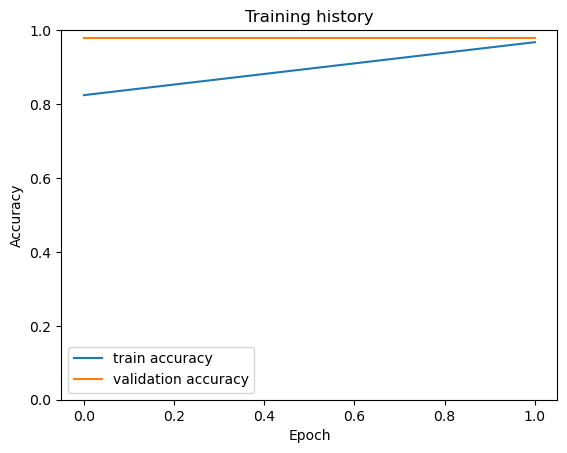

In [38]:
plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [39]:
test_acc, _ = eval_model(

  clinic_model,

  test_data_loader,

  loss_fn,

  device,

  len(test_df)

)

test_acc.item()

0 , 3 , type a, type b problem # 2 : cough. the patient presented with aggressive cough. she had a chest ct done, which showed minimal central _ _ _ _ _ _ passage to upper lobes bilaterally, a nonspecific finding. the patient had cultures done. at the time of discharge, they were negative for ab by stain. however, cultures will be called several weeks after culture. problem # 3. hypertension. the patient will continue her medications she was on, which includes norvasc and hydrochlorothiazide.
0 , 3 , type a, type b a herpes simplex virus swab was sent on his lower lip lesion, although the results were erroneously canceled on the computer. influenza ab was sent and was negative. he had several blood cultures during his hospitalization, as well as a urine culture, which all remained negative, with no growth.


0.96

In [40]:
def get_predictions(model, data_loader):

  model = model.eval()

  text = []

  predictions = []

  real_values = []
  texts = []
  

  with torch.no_grad():

    for d in data_loader:


      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)


      targets = d["label_"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask,
        token_type_ids = token_type_ids,

      )

      _, preds = torch.max(outputs, dim=1)

      #for xx in input_ids:
        #text.extend(tokenizer.decode(xx,skip_special_tokens=True))

      predictions.extend(preds)

      real_values.extend(d['label_'])
  texts.extend(text)

  predictions = torch.stack(predictions).cpu()

  #texts = torch.stack(texts).cpu()

  real_values = torch.stack(real_values).cpu()

  return  predictions, real_values

In [41]:
y_pred, y_test = get_predictions(clinic_model,test_data_loader)


In [42]:
text = []
for d in test_data_loader:
  for dd in d['input_ids']:
    text.append(tokenizer.decode(dd, skip_special_tokens=True))

In [43]:
prediction = []
for i in y_pred:
  prediction.append(i.item())
len(prediction)

50

In [44]:
real = []
for i in y_test:
  real.append(i.item())
len(real)

50

In [45]:
test_result_df = pd.DataFrame()
test_result_df['text'] = text
test_result_df['prediction'] = prediction
test_result_df['real'] = real


In [46]:
test_result_df.to_csv('test_result_prediction.tsv', sep = '|')

In [47]:
#print(classification_report(y_test, y_pred, target_names=class_names))
#print(y_pred)
for i in y_pred:
  print(i)

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
